## Redshift Catastrophics Analysis

This notebook analyzes redshift uncertainties in DESI mock data for the ELG_LOPnotqso tracer, focusing on the ratio of redshift catastrophics and velocity distributions. It includes:
- Calculation of redshift discrepancy ratios for `Z_realistic` and `Z_failures`
- Log-normal distribution analysis for velocity deviations in redshift catastrophics
- Comparison of n(z) distributions between fiducial and catastrophic cases

This provides insights into the systematic effects of redshift errors on clustering measurements.


In [1]:
import os
import glob
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
nran_list = {'ELG_LOPnotqso':10, 'LRG':8, 'QSO':2}

survey  ='Y1'
specver ='iron'
mockver ='v4_2'
tracer  = 'ELG_LOPnotqso'
region  ='SGC' #region NGC, SGC, GCcomb
nran = nran_list[tracer]

MOCKNUM = 0
file_path = f'/pscratch/sd/s/shengyu/mocks/{survey}/Abacus_{mockver}/altmtl{MOCKNUM}/{specver}/mock{MOCKNUM}/LSScats'
mock_type = 'clustering' #clustering or full_HPmapcut (before z selection and FKP weight assigments)

ran_mocks   = []
dat_mocks  =  [] 
ran_mocks_fn = []
dat_mocks_fn = []

for dn in ['ran','dat']:
    if dn == 'ran':
        for i in range(nran):
            pattern = os.path.join(file_path, f'{tracer}_{region}_{i}_{mock_type}.{dn}.fits')
            ran_mocks_fn.append(glob.glob(pattern))
            with fits.open(pattern, memmap=True) as hdul:
                ran_mocks.append(hdul[1].data)
    if dn == 'dat':
        dat_mocks_fn = glob.glob(os.path.join(file_path, f'{tracer}_{region}_{mock_type}.{dn}.fits'))[0]
        with fits.open(dat_mocks_fn, memmap=True) as hdul:
            dat_mocks = hdul[1].data
            
# hdul.info()
print('random mocks:', len(ran_mocks))
print(dat_mocks.names, '\n', dat_mocks[:3], '\n', len(dat_mocks))

random mocks: 10
['TARGETID', 'RA', 'DEC', 'Z', 'NTILE', 'PHOTSYS', 'FRAC_TLOBS_TILES', 'Z_realistic', 'Z_failures', 'WEIGHT', 'WEIGHT_ZFAIL', 'WEIGHT_COMP', 'WEIGHT_SYS', 'NX', 'WEIGHT_FKP'] 
 [(10718826, 354.53183, 26.57135 , 1.2198685, 1, 'S', 0.49231678, 1.2198685, 1.2198685, 0.95749026, 1., 3., 1., 8.13345770e-05, 0.75452433)
 (19457570, 355.74722, 24.713867, 1.1555287, 1, 'S', 0.49231678, 1.1555287, 1.5539356, 1.59581711, 1., 5., 1., 8.63896313e-05, 0.74318581)
 ( 6311889, 355.45206, 24.694435, 1.0958817, 1, 'S', 0.49231678, 1.0958817, 1.0958817, 1.27665369, 1., 4., 1., 9.03846054e-05, 0.7344633 )] 
 602009


In [3]:
# Calculating the ratio of redshift catastrophics
z_diff = dat_mocks['Z']-dat_mocks['Z_realistic']

print('initial:',len(z_diff))
print('dz nonzero:',len(z_diff[np.nonzero(z_diff)]))
print('abs(dz)>0.01:',len(z_diff[np.abs(z_diff)>0.01]))
print('abs(dz)>0.001:',len(z_diff[np.abs(z_diff)>0.001]))

print('Z_realistic ratio:', len(z_diff[np.abs(z_diff)>0.01])/len(z_diff))
z_diff = dat_mocks['Z']-dat_mocks['Z_failures']
# print(Z_diff[np.nonzero(Z_diff)])
print('Z_failures ratio:',len(z_diff[np.abs(z_diff)>0.01])/len(z_diff))

initial: 602009
dz nonzero: 1637
abs(dz)>0.01: 1621
abs(dz)>0.001: 1636
Z_realistic ratio: 0.0026926507743239717
Z_failures ratio: 0.01033871586637409


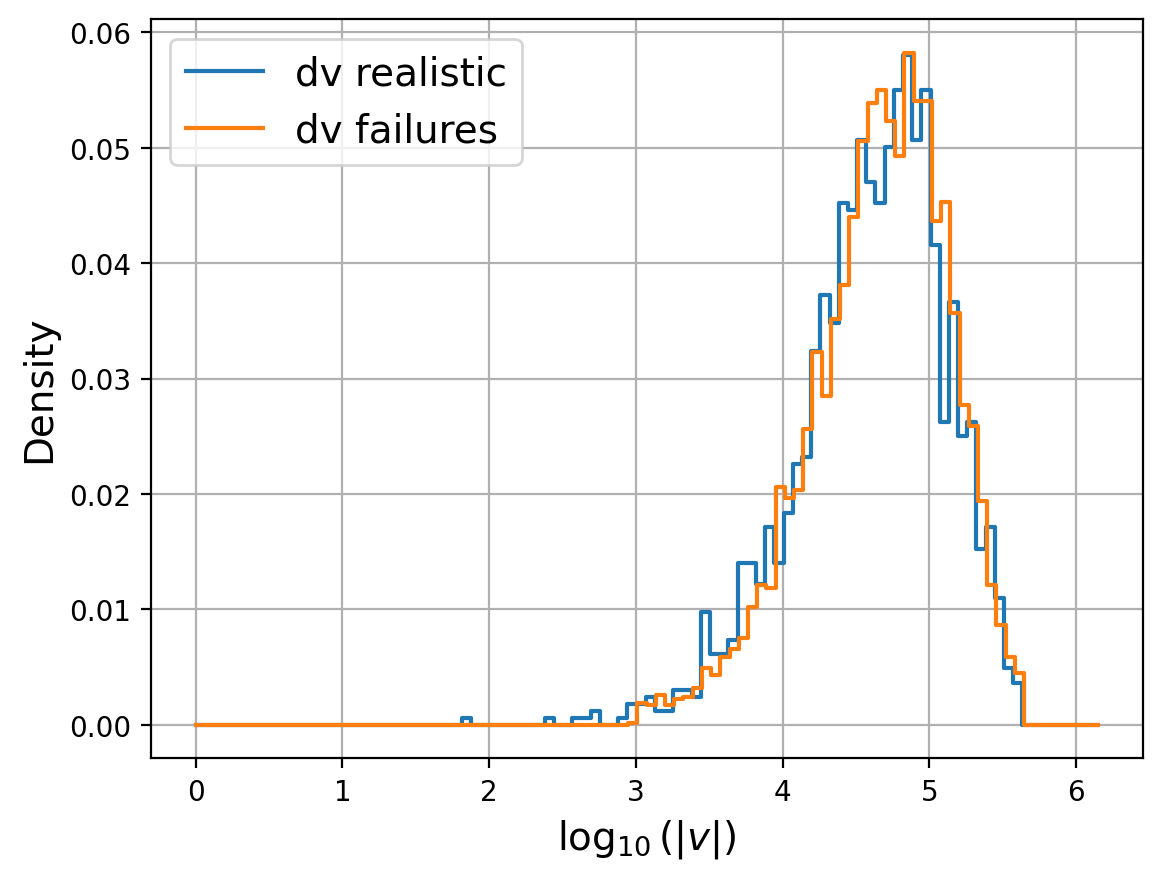

In [4]:
# dv distribution (should be a log-normal distribution for the redshift catastrophics)
def plot_bins(data, bins=None, num_bins=100):
    if bins == None:
        bins = np.linspace(0, max(data)*(1.1), num_bins)
    n, bin_edges = np.histogram(data, bins=bins)
    n_rs = n / np.sum(n)
    return(bin_edges[:-1],n_rs)

c = 299792 # speed of light in km/s
dv_labels = ['dv realistic', 'dv failures']
for i,zcatas_fn in enumerate(['Z_realistic', 'Z_failures']):
    z_diff = dat_mocks['Z']-dat_mocks[zcatas_fn]
    delta_z = z_diff[np.nonzero(z_diff)]
    delta_v = abs(delta_z*c/(1+dat_mocks['Z'][np.nonzero(z_diff)]))
    log_delta_v = np.log10(delta_v)
    (x,y)=plot_bins(log_delta_v)
    plt.plot(x, y, drawstyle='steps-post',label=dv_labels[i])
plt.legend()
plt.ylabel(r'Density')
plt.grid(True)
plt.xlabel(r'$\log_{10}(|v|)$')
plt.show()

3


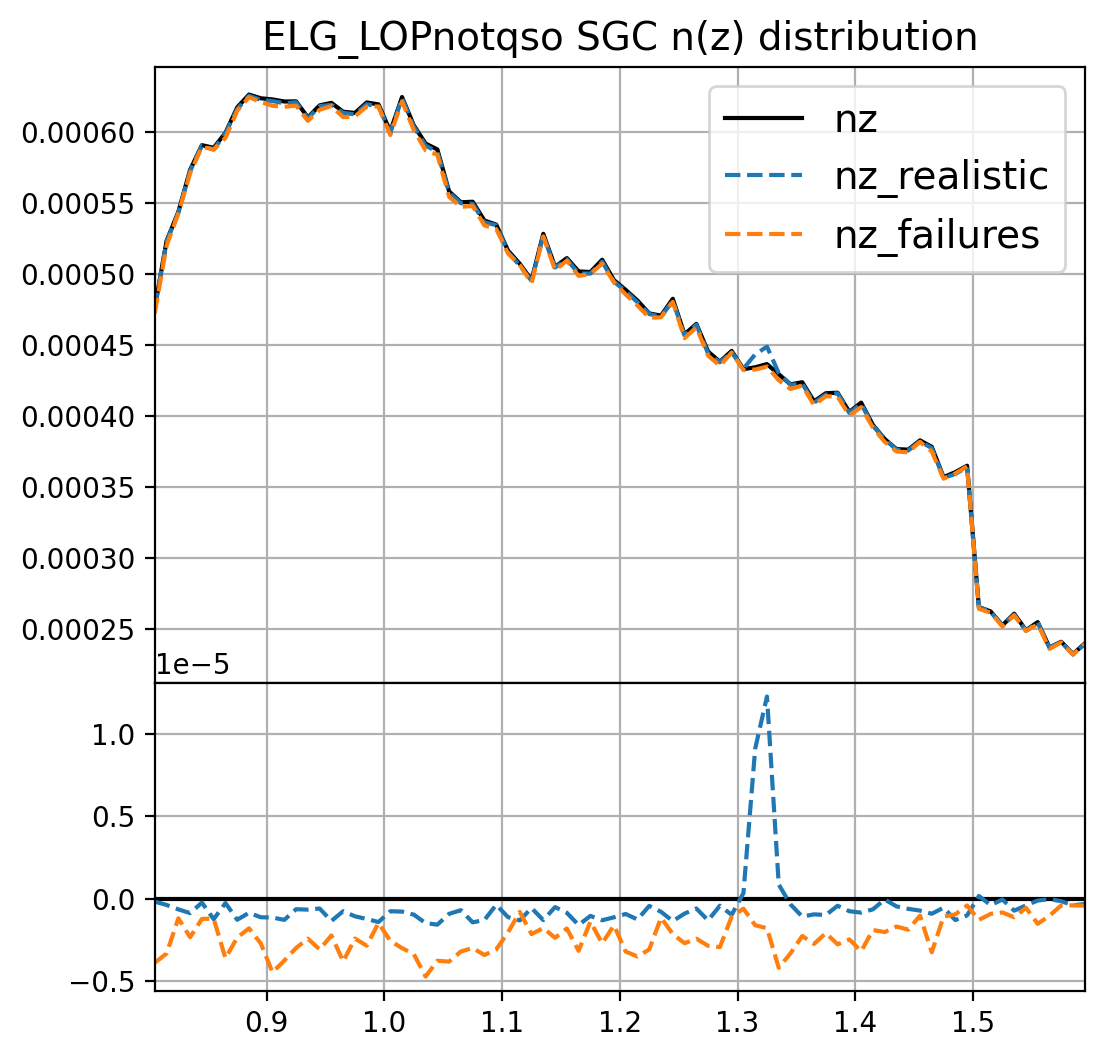

In [8]:
#zmid zlow zhigh n(z) Nbin Vol_bin
nz_columes = {'n(z)':3, 'Nbin':4, 'Vol_bin':5}

nplot = 'n(z)'
colume = nz_columes[nplot]
print(colume)
z_labels = ['nz', 'nz_realistic','nz_failures']
fig, ax = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1], 'hspace': 0}, sharex=True)
for i,nz_fn in enumerate(z_labels):
    nz = np.loadtxt(file_path+f'/{tracer}_{region}_{nz_fn}.txt')
    if i == 0:
        nz_fiducial = nz
        zmid = nz_fiducial[:,0]
        ax[0].set_xlim(min(nz[:,0]), max(nz[:,0]))
        ax[0].plot(zmid,nz_fiducial[:,colume],color='black', label=z_labels[i])
        ax[1].plot(zmid, [0]*len(zmid),color='black')
    if i>0:
        nz_catas = nz
        ax[0].plot(zmid, nz_catas[:,colume], label=z_labels[i], ls='--')
        ax[1].plot(zmid, nz_catas[:,colume]-nz_fiducial[:,colume], ls='--')

ax[0].set_title(f'{tracer} {region} {nplot} distribution')
ax[0].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()